# Starting a pharmacy business in Buenos Aires
### Final coursera capstone project
### By Jose Ignacio Chajchir

In [1]:
# If necessary, install these libraries to run this notebook:

#!pip install geopy
#!pip install requests
#!pip install matplotlib
#!pip install sklearn
#!pip install folium
#!pip install pandas
#!pip install fuzzywuzzy
# conda install geopandas (should be run from command window)

In [2]:
import numpy as np # library to handle data in a vectorized manner

# library for data analsysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Data acquisition and cleaning
### How many pharmacies already exist in the neighborhood?

In [3]:
# Locate CABA by searching for a center location.
address = 'Corrientes 1200, CABA, Argentina'
geolocator = Nominatim(user_agent="CABA_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Bs As are {}, {}.'.format(latitude, longitude))

# create map
map_caba = folium.Map(location=[latitude, longitude], zoom_start=11)
map_caba

The geographical coordinate of Bs As are -34.6041224, -58.4053431.


In [4]:
#Let´s get shape file from Argentina provinces to download CABA polygon. 

#Creates local folder in C drive if doesn´t exists
import os
if not os.path.exists('C:/coursera_final_capstone'):
    os.makedirs('C:/coursera_final_capstone')
    
#Downloads the file to the local folder
url = 'https://infra.datos.gob.ar/catalog/modernizacion/dataset/7/distribution/7.34/download/provincias.zip'
import urllib.request 
urllib.request.urlretrieve(url, 'C:/coursera_final_capstone/provincias.zip')

#Unzip de file to get the shp file
import zipfile
from zipfile import ZipFile

with ZipFile("C:/coursera_final_capstone/provincias.zip", 'r') as zipf:
        zipf.extract("provincias/provincias.shp","C:/coursera_final_capstone")
        
with ZipFile("C:/coursera_final_capstone/provincias.zip", 'r') as zipf:
        zipf.extract("provincias/provincias.shx","C:/coursera_final_capstone")        

In [5]:
# Code to extract CABA polygon from shape file. The bbox was defined using 2 points extracted from google maps.

import geopandas
bbox = (-58.4383, -34.6191, -58.2914, -34.5406)

# check caba polygon
shp_file = geopandas.read_file('C:/coursera_final_capstone/provincias/provincias.shp',bbox=bbox)
shp_file.to_file('C:/coursera_final_capstone/provincias/provincias.geojson', driver='GeoJSON')
folium.GeoJson('C:/coursera_final_capstone/provincias/provincias.geojson').add_to(map_caba)
map_caba

In [6]:
#convert previous geojson file to geopandas to run contain function afterwards
import geopandas as gpd
df = gpd.read_file('C:/coursera_final_capstone/provincias/provincias.geojson')

In [7]:
#code to test contains function
#points were manually selected obtaining latitude and Longitude from google maps.
from shapely.geometry import Point
point=Point(-58.430841, -34.664909)
print(df.geometry.contains(point))
point=Point(-58.430841, -34.964909)
print(df.geometry.contains(point))

0    True
dtype: bool
0    False
dtype: bool


In [8]:
# get the bounding box limits of the CABA polygon in order to build matrix
df['geometry'].bounds

,minx,miny,maxx,maxy
0,-58.531465,-34.705315,-58.335146,-34.526526


In [9]:
#Although the API let you search only for pharmacies (by setting category ID) there´s a limit of 50 results per request. 
#Therefore, data for the complete CABA area had to be collected using multiple requests, where each request 
#belonged to a unique geographic point inside CABA area

#define area to build the grid

from geopy.distance import geodesic

p1= (df['geometry'].bounds['maxy'].item(), df['geometry'].bounds['minx'].item())  # (latitude, longitude) don't confuse
p2= (df['geometry'].bounds['maxy'].item(), df['geometry'].bounds['maxx'].item())

grid_length=geodesic(p1, p2).meters

p3= (df['geometry'].bounds['miny'].item(), df['geometry'].bounds['minx'].item())

grid_height=geodesic(p1, p3).meters

print("the length of the meshgrid is", grid_length,"meters")
print("the height of the meshgrid is", grid_height, "meters")

the length of the meshgrid is 18024.253777757633 meters
the height of the meshgrid is 19833.750232163566 meters


In [10]:
#define size of the grid
l=710 #size of square in meters. NOTE: size of squares and radius for Foursquare API were defined together in order to cover total area.
lx=int(grid_length/l)+1
ly=int(grid_height/l)+1

print("The length of the meshgrid is",lx,"squares, where each of them has a side length of",l,"meters")
print("The height of the meshgrid is",ly,"squares, where each of them has a side length of",l,"meters")

The length of the meshgrid is 26 squares, where each of them has a side length of 710 meters
The height of the meshgrid is 28 squares, where each of them has a side length of 710 meters


In [11]:
#define grid

p4= (df['geometry'].bounds['miny'].item(), df['geometry'].bounds['maxx'].item())

x = np.linspace(df['geometry'].bounds['minx'].item(), df['geometry'].bounds['maxx'].item(), lx)
y = np.linspace(df['geometry'].bounds['miny'].item(), df['geometry'].bounds['maxy'].item(), ly)

In [12]:
#get number of points
xv,yv=np.meshgrid(x,y)
xv=xv.flatten()
yv=yv.flatten()
xv.shape

(728,)

In [13]:
#create dataset for plotting the grid
dataset = pd.DataFrame({'X': xv[:],'Y':yv[:]})

#plot
for i in range(0,len(dataset)):
    folium.CircleMarker([dataset.iloc[i]['Y'], dataset.iloc[i]['X']],radius=1,color = 'grey').add_to(map_caba)
map_caba

In [14]:
#creates column to define if points is in or out of Caba polygon
dataset['caba']=""

In [15]:
#iterate through dataset
for row in range(0,len(dataset)):
    point=Point(dataset['X'].loc[row], dataset['Y'].loc[row])
    t=df.geometry.contains(point)
    dataset.loc[row,'caba']=t.iloc[0]

In [16]:
#check how dataset looks
dataset.head()

,X,Y,caba
0,-58.531465,-34.705315,False
1,-58.523612,-34.705315,False
2,-58.515760,-34.705315,False
3,-58.507907,-34.705315,False
4,-58.500054,-34.705315,False


In [17]:
#plot points again and see which are inside

for i in range(0,len(dataset)):
    if dataset['caba'].loc[i]==True:
        color="green"
    else:
        color="red"
    folium.CircleMarker([dataset.iloc[i]['Y'], dataset.iloc[i]['X']],radius=1,color = color).add_to(map_caba)
map_caba

In [18]:
#the green dots (inside CABA - true) will be used to get foursquare data. How many are they?
dataset.groupby(['caba']).size()

caba
False    341
True     387
dtype: int64

In [19]:
#creates new dataframe with only caba points
caba_dots=dataset.copy()
caba_dots=dataset.loc[dataset['caba']==True]
caba_dots=caba_dots.reset_index(drop=True)
caba_dots.shape

(387, 3)

In [20]:
#create "point_number" column
caba_dots['point_number']=caba_dots.index
caba_dots=caba_dots[['point_number',"X","Y"]]
caba_dots.head()

,point_number,X,Y
0,0,-58.468643,-34.698693
1,1,-58.460790,-34.698693
2,2,-58.476496,-34.692071
3,3,-58.468643,-34.692071
4,4,-58.460790,-34.692071


### Foursquare data acquisition

In [21]:
# credentials needed for foursquare
CLIENT_ID = 'P0FH3BWUSRULJ30JWFNKC31BNHCCZ1JRL52L3DKMJGSAEOJ4' # your Foursquare ID
CLIENT_SECRET = 'LZOO2GSFQLONLD4ACPS3ZYYAU0NJCCYL2WVTDQTX5UHCY3CE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 10000 # A default Foursquare API limit value

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [22]:
# Creates function that extracts data from foursquare and compiles in one single dataframe
# In order to search for pharmacies only, categoryId was set to '4bf58dd8d48988d10f951735'

def getNearbyPharmacies(point_number, latitudes, longitudes, radius=500):
    pharmacies_df_final=pd.DataFrame(columns=['Point_number','Point Latitude','Point Longitude','Pharmacy name','Pharmacy Latitude','Pharmacy Longitude','Pharmacy distance to point','Pharmacy Adress'])    

    for point, lat, lng in zip(point_number, latitudes, longitudes):
        print(point)
      
        # create the API request URL
        categoryId= '4bf58dd8d48988d10f951735'
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION, 
            radius, 
            LIMIT, 
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        # creates data frame with point information
        resultsdf=json_normalize(results)
        if (len(resultsdf)>0):
            pharmacies_df=pd.DataFrame(columns=['Point_number','Point Latitude','Point Longitude','Pharmacy name','Pharmacy Latitude','Pharmacy Longitude','Pharmacy distance to point','Pharmacy Adress'])
            pharmacies_df['Pharmacy name']=resultsdf['name']
            pharmacies_df['Pharmacy Latitude']=resultsdf['location.lat']
            pharmacies_df['Pharmacy Longitude']=resultsdf['location.lng']
            pharmacies_df['Pharmacy distance to point']=resultsdf['location.distance']
            try:
                pharmacies_df['Pharmacy Address']=resultsdf['location.address']
            except:
                pharmacies_df['Pharmacy Address']=None
            pharmacies_df['Point_number']=point
            pharmacies_df['Point Latitude']=lat
            pharmacies_df['Point Longitude']=lng
        
            pharmacies_df_final=pharmacies_df_final.append(pharmacies_df,ignore_index=True)

    return(pharmacies_df_final)

In [23]:
## Execute function. As this function uses foursquare account that has a daily limit for search queries, the data was downloaded
# to a csv file. Therefore, below I am showing both ways of getting the data.

# Option 1: Apply function
caba_pharmacies=getNearbyPharmacies(caba_dots['point_number'], caba_dots['Y'], caba_dots['X'])

# Option 2: Get data from csv
# caba_pharmacies=pd.read_csv("https://github.com/Jose-igna/Coursera_Capstone/raw/main/The_Battle_of_Neighborhoods/caba_pharmacies.csv")

0


<ipython-input-22-3f0dae76a443>:26: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  resultsdf=json_normalize(results)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [24]:
#  This code was executed once in order to save the data and avoid using the foursquare account
#caba_pharmacies.to_csv("C:/coursera_final_capstone/caba_pharmacies.csv")

In [25]:
# Create dataframe droping repeated pharmacies
unique_caba_pharmacies=caba_pharmacies.reset_index().drop_duplicates(subset=['Pharmacy Latitude','Pharmacy Longitude'],keep='first')
unique_caba_pharmacies=unique_caba_pharmacies.drop(['index'],axis=1).reset_index(drop=True)
try:
    unique_caba_pharmacies=unique_caba_pharmacies.drop(['Unnamed: 0'],axis=1).reset_index(drop=True)
except:
    None
unique_caba_pharmacies

,Point_number,Point Latitude,Point Longitude,Pharmacy name,Pharmacy Latitude,Pharmacy Longitude,Pharmacy distance to point,Pharmacy Adress,Pharmacy Address
0,2,-34.692071,-58.476496,Farmacia San Pedro,-34.690053,-58.481157,482,NaN,Cabildo
1,7,-34.685449,-58.476496,Farmacity,-34.686374,-58.476301,104,NaN,Cnel. Martiniano Chilavert 6461
2,7,-34.685449,-58.476496,Farmacia Belen,-34.685821,-58.475219,123,NaN,Cnel. Martiniano Chilavert 6364
3,7,-34.685449,-58.476496,Óptica Sacaria,-34.686685,-58.476368,138,NaN,Chilavert
4,9,-34.685449,-58.460790,Farmacia San Alberto,-34.686954,-58.461395,176,NaN,Cañada De Gomez 5201
5,14,-34.678828,-58.476496,Farmacia Inglesa,-34.676492,-58.476758,261,NaN,Somellera 5725
6,14,-34.678828,-58.476496,Optica De Betina,-34.677923,-58.474880,178,NaN,NaN
7,14,-34.678828,-58.476496,Farmacia Cientifica,-34.676375,-58.475732,281,NaN,NaN
8,16,-34.678828,-58.460790,FarmaServ,-34.675319,-58.459161,418,NaN,Factory Parque Brown
9,22,-34.672206,-58.476496,Farmacia Belén,-34.672939,-58.473366,297,NaN,Av. Riesta


In [26]:
#check if foursquare queries hit the limit of 50 venues
unique_caba_pharmacies.groupby('Point_number').size().max()

20

In [27]:
#Get neighborhood boundaries 
#Downloads gejson file of Caba neighborhoods
url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/barrios/barrios.geojson'
urllib.request.urlretrieve(url, 'C:/coursera_final_capstone/barrios.geojson')

('C:/coursera_final_capstone/barrios.geojson',
 <http.client.HTTPMessage at 0x23ecf414d90>)

In [28]:
# plot neighborhoods
map_caba_neigh = folium.Map(location=[latitude, longitude], zoom_start=11)

folium.GeoJson('C:/coursera_final_capstone/barrios.geojson').add_to(map_caba_neigh)

map_caba_neigh

In [29]:
#code to get to which neighborhood each pharmacy belongs

import json
from shapely.geometry import shape, GeometryCollection, Point
with open('C:/coursera_final_capstone/barrios.geojson') as f:
    js = json.load(f)
    
unique_caba_pharmacies['Neighborhood']=""    
    
for i in range(0,len(unique_caba_pharmacies)):
    
    point = Point(unique_caba_pharmacies.loc[i,'Pharmacy Longitude'], unique_caba_pharmacies.loc[i,'Pharmacy Latitude'])

    for feature in js['features']:

        polygon = shape(feature['geometry'])

        if polygon.contains(point):
            unique_caba_pharmacies.loc[i,'Neighborhood']=feature['properties']['barrio']

In [30]:
#drop rows without assigned neighborhood
unique_caba_pharmacies=unique_caba_pharmacies[unique_caba_pharmacies['Neighborhood'].str.strip().astype(bool)].reset_index(drop=True)

In [31]:
#Lets count how many pharmcies are there in each Neighborhood
caba_neighborhoods=unique_caba_pharmacies.groupby(['Neighborhood']).size().reset_index(name='counts')
caba_neighborhoods.head()

,Neighborhood,counts
0,ALMAGRO,26
1,BALVANERA,52
2,BARRACAS,16
3,BELGRANO,43
4,BOCA,4


### How many persons live? How old are them?

In [33]:
# get data form statistics about neighborhood population

#dfpobla = pd.read_excel('https://www.estadisticaciudad.gob.ar/eyc/?p=28008/PB_barrio_ARIP_CNP2010.xls') 
#NOTE: site https://www.estadisticaciudad.gob.ar/ doesn´t longer work. Using backup:
dfpobla = pd.read_excel('https://github.com/Jose-igna/Coursera_Capstone/raw/main/The_Battle_of_Neighborhoods/PB_barrio_ARIP_CNP2010.xls')

In [34]:
# remove nans
for i in range(0,len(dfpobla.columns)):
    if str(dfpobla.iloc[0,i])=='nan':
        dfpobla.iloc[0,i]=dfpobla.iloc[0,i-1]

In [35]:
# clean table
dfpobla.iloc[1,:] = dfpobla.iloc[1,:].fillna('')
dfpobla.columns = dfpobla.iloc[0,:]+"_"+dfpobla.iloc[1,:]
dfpobla.drop(dfpobla.columns[dfpobla.columns.str.contains('Total')], axis=1, inplace=True)
dfpobla.drop(dfpobla.index[[0,1,2]],inplace=True)
dfpobla.drop(dfpobla.loc[dfpobla['Barrio_']=='Total '].index, inplace=True)
dfpobla.drop(dfpobla.loc[dfpobla['Barrio_']=='Total'].index, inplace=True)
dfpobla.drop(columns=['Comuna_'], inplace=True)
dfpobla.reset_index(drop=True, inplace=True)
dfpobla.dropna(subset=['Barrio_'],inplace=True)

In [36]:
dfpobla.head()

,Barrio_,0-4_Varón,0-4_Mujer,5-9_Varón,5-9_Mujer,10-14_Varón,10-14_Mujer,15-19_Varón,15-19_Mujer,20-24_Varón,20-24_Mujer,25-29_Varón,25-29_Mujer,30-34_Varón,30-34_Mujer,35-39_Varón,35-39_Mujer,40-44_Varón,40-44_Mujer,45-49_Varón,45-49_Mujer,50-54_Varón,50-54_Mujer,55-59_Varón,55-59_Mujer,60-64_Varón,60-64_Mujer,65-69_Varón,65-69_Mujer,70-74_Varón,70-74_Mujer,75-79_Varón,75-79_Mujer,80-84_Varón,80-84_Mujer,85-89_Varón,85-89_Mujer,90-94_Varón,90-94_Mujer,95 y más_Varón,95 y más_Mujer
0,Constitucion,1197,1245,1206,1238,1232,1215,1310,1322,1893,1784,2033,1974,1919,1863,1617,1696,1376,1539,1274,1430,1317,1415,1153,1263,892,1189,695,1013,522,857,464,839,303,735,194,499,54,243,15,82
1,Monserrat,956,906,869,825,860,820,1054,1085,1933,1836,2130,2182,2045,1824,1554,1637,1286,1333,1134,1270,1145,1269,955,1167,875,1096,679,1003,536,779,397,785,318,576,149,377,57,157,8,47
2,Puerto Madero,287,257,191,160,171,142,167,138,324,273,368,334,350,323,361,315,260,229,211,181,226,197,191,183,227,170,137,88,74,52,40,30,16,25,8,12,2,4,NaN,2
3,Retiro,2500,2365,1898,1964,1805,1833,2024,2141,3220,3554,3415,3398,2867,2778,2353,2352,1842,1970,1704,1812,1570,1736,1387,1697,1286,1606,1099,1291,759,1055,582,889,491,829,265,559,102,282,26,107
4,San Nicolas,506,466,440,437,476,529,655,686,1515,1520,1767,1864,1545,1460,1127,1056,943,886,902,907,948,954,802,961,746,850,581,727,415,610,293,474,233,420,108,277,35,100,9,43


In [37]:
# get data about total population and +65 years old population
dfpobla_total=dfpobla.copy()

cols_to_sum_total = dfpobla_total.columns[ 1: dfpobla_total.shape[1]]
cols_to_sum_more_65 = dfpobla_total.columns[ dfpobla_total.columns.get_loc("65-69_Varón"): dfpobla_total.shape[1]]
dfpobla_total['Total'] = dfpobla_total[cols_to_sum_total].sum(axis=1)
dfpobla_total['Total_more_65'] = dfpobla_total[cols_to_sum_more_65].sum(axis=1)
dfpobla_total.drop(columns=cols_to_sum_total, inplace=True)
dfpobla_total['Barrio_']=dfpobla_total['Barrio_'].str.upper()
dfpobla_total['Barrio_']=dfpobla_total['Barrio_'].str.lstrip()
dfpobla_total['Barrio_']=dfpobla_total['Barrio_'].str.rstrip()
dfpobla_total = dfpobla_total.rename(columns={'Barrio_': 'Neighborhood'})
dfpobla_total.head()

,Neighborhood,Total,Total_more_65
0,CONSTITUCION,44107.0,6515.0
1,MONSERRAT,39914.0,5868.0
2,PUERTO MADERO,6726.0,490.0
3,RETIRO,65413.0,8336.0
4,SAN NICOLAS,29273.0,4325.0


In [38]:
#merge these two datasets
df_merged = dfpobla_total.merge(caba_neighborhoods, left_on="Neighborhood", right_on="Neighborhood", how="left")
df_merged.head()

,Neighborhood,Total,Total_more_65,counts
0,CONSTITUCION,44107.0,6515.0,7.0
1,MONSERRAT,39914.0,5868.0,30.0
2,PUERTO MADERO,6726.0,490.0,4.0
3,RETIRO,65413.0,8336.0,22.0
4,SAN NICOLAS,29273.0,4325.0,48.0


In [39]:
#get neighbourhoods with umerged data
unmerged=df_merged[df_merged.isnull().any(axis=1)]
unmerged

,Neighborhood,Total,Total_more_65,counts
10,LA BOCA,45113.0,5661.0,NaN
20,VILLA SOLDATI,46779.0,3603.0,NaN
27,VERSALLES,13822.0,2503.0,NaN
30,VILLA MITRE,34713.0,5421.0,NaN
40,NUÐEZ,51949.0,8686.0,NaN
42,AGRONOMIA,13912.0,2489.0,NaN


In [39]:
#!pip install fuzzywuzzy #If necessary, install this library

In [40]:
#let´s check if the unmerged data was not merged because of little differences in spelling
from fuzzywuzzy import process
from fuzzywuzzy import fuzz

caba_neigh_list=caba_neighborhoods['Neighborhood'].tolist()

for i in range(0, len(unmerged)):
    print(unmerged.iloc[i]['Neighborhood'])
    test_list=[unmerged.iloc[i]['Neighborhood']] + caba_neigh_list
    print(process.extract(unmerged.iloc[i]['Neighborhood'], test_list, scorer=fuzz.ratio))


LA BOCA
[('LA BOCA', 100), ('BOCA', 73), ('VILLA ORTUZAR', 50), ('VILLA LURO', 47), ('VILLA REAL', 47)]
VILLA SOLDATI
[('VILLA SOLDATI', 100), ('VILLA SANTA RITA', 69), ('VILLA CRESPO', 64), ('VILLA DEVOTO', 64), ('VILLA ORTUZAR', 62)]
VERSALLES
[('VERSALLES', 100), ('COLEGIALES', 53), ('VILLA CRESPO', 48), ('PATERNAL', 47), ('SAAVEDRA', 47)]
VILLA MITRE
[('VILLA MITRE', 100), ('VILLA GRAL. MITRE', 79), ('VILLA REAL', 76), ('VILLA CRESPO', 70), ('VILLA LURO', 67)]
NUÐEZ
[('NUÐEZ', 100), ('NUÃ‘EZ', 73), ('LINIERS', 33), ('NUEVA POMPEYA', 33), ('BALVANERA', 29)]
AGRONOMIA
[('AGRONOMIA', 100), ('ALMAGRO', 50), ('BELGRANO', 47), ('PATERNAL', 47), ('CHACARITA', 44)]


C:\Users\jx09182\.conda\envs\Capstone2\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [41]:
# code to reeplace neighborhood names in caba_neighobourhoods data frame (Neighborhood columns). Scores higher than 70 are kept.
for i in range(0, len(unmerged)):
    test_list=[unmerged.iloc[i]['Neighborhood']] + caba_neigh_list
    temp_list=process.extract(unmerged.iloc[i]['Neighborhood'], test_list, scorer=fuzz.ratio)
    if temp_list[1][1]>70:
        print(unmerged.iloc[i]['Neighborhood'])
        caba_neighborhoods.replace(temp_list[1][0],unmerged.iloc[i]['Neighborhood'],inplace=True)

LA BOCA
VILLA MITRE
NUÐEZ


In [42]:
# run again to merge datasets
df_merged = dfpobla_total.merge(caba_neighborhoods, left_on="Neighborhood", right_on="Neighborhood", how="left")
df_merged.head()

,Neighborhood,Total,Total_more_65,counts
0,CONSTITUCION,44107.0,6515.0,7.0
1,MONSERRAT,39914.0,5868.0,30.0
2,PUERTO MADERO,6726.0,490.0,4.0
3,RETIRO,65413.0,8336.0,22.0
4,SAN NICOLAS,29273.0,4325.0,48.0


### Are these persons consumers of pharmacy products? 

In [43]:
# get data of cost per squere meter per neighborhood (considered to be correlated with income)
# csv data was obtained from site https://www.zonaprop.com.ar/noticias/zpindex/

neighborhoods_cost=pd.read_csv("https://github.com/Jose-igna/Coursera_Capstone/raw/main/The_Battle_of_Neighborhoods/costo_m2_barrio.csv")
neighborhoods_cost = neighborhoods_cost.rename(columns={'Barrio': 'Neighborhood'})
neighborhoods_cost.head()

,Neighborhood,USD/m2
0,Puerto Madero,5786
1,Palermo,3313
2,Belgrano,3164
3,Nuðez,3039
4,Recoleta,2973


In [44]:
# set uppercase and merge
neighborhoods_cost['Neighborhood']=neighborhoods_cost['Neighborhood'].str.upper()
df_merged2 = df_merged.merge(neighborhoods_cost, left_on="Neighborhood", right_on="Neighborhood", how="left")
df_merged2.head()

,Neighborhood,Total,Total_more_65,counts,USD/m2
0,CONSTITUCION,44107.0,6515.0,7.0,1960
1,MONSERRAT,39914.0,5868.0,30.0,2083
2,PUERTO MADERO,6726.0,490.0,4.0,5786
3,RETIRO,65413.0,8336.0,22.0,2926
4,SAN NICOLAS,29273.0,4325.0,48.0,2163


In [45]:
#replace NaN values
df_merged2.counts = df_merged2.counts.fillna(0)
#clean dataset
df_merged2.rename(columns={"Total": "Total_pop", "Total_more_65": "Total_pop_+65", "counts": "Pharmacies" }, inplace=True)

In [46]:
#Create calculated columns
df_merged2['pop_per_pharma']=df_merged2['Total_pop']/df_merged2['Pharmacies']
df_merged2['+65pop_per_pharma']=df_merged2['Total_pop_+65']/df_merged2['Pharmacies']
df_merged2.style.set_precision(2)

,Neighborhood,Total_pop,Total_pop_+65,Pharmacies,USD/m2,pop_per_pharma,+65pop_per_pharma
0,CONSTITUCION,44107.00,6515.00,7.00,1960,6301.00,930.71
1,MONSERRAT,39914.00,5868.00,30.00,2083,1330.47,195.60
2,PUERTO MADERO,6726.00,490.00,4.00,5786,1681.50,122.50
3,RETIRO,65413.00,8336.00,22.00,2926,2973.32,378.91
4,SAN NICOLAS,29273.00,4325.00,48.00,2163,609.85,90.10
5,SAN TELMO,20453.00,3590.00,8.00,2417,2556.62,448.75
6,RECOLETA,157932.00,31265.00,88.00,2973,1794.68,355.28
7,BALVANERA,138926.00,22096.00,52.00,2043,2671.65,424.92
8,SAN CRISTOBAL,48611.00,7932.00,6.00,2015,8101.83,1322.00
9,BARRACAS,89452.00,9724.00,16.00,2364,5590.75,607.75


In [47]:
#replace infinate data with max values of columns
max1 = df_merged2.loc[df_merged2['pop_per_pharma'] != np.inf, 'pop_per_pharma'].max()
df_merged2['pop_per_pharma'].replace(np.inf,max1,inplace=True)

max2 = df_merged2.loc[df_merged2['+65pop_per_pharma'] != np.inf, '+65pop_per_pharma'].max()
df_merged2['+65pop_per_pharma'].replace(np.inf,max2,inplace=True)

df_merged2.head()

,Neighborhood,Total_pop,Total_pop_+65,Pharmacies,USD/m2,pop_per_pharma,+65pop_per_pharma
0,CONSTITUCION,44107.0,6515.0,7.0,1960,6301.000000,930.714286
1,MONSERRAT,39914.0,5868.0,30.0,2083,1330.466667,195.600000
2,PUERTO MADERO,6726.0,490.0,4.0,5786,1681.500000,122.500000
3,RETIRO,65413.0,8336.0,22.0,2926,2973.318182,378.909091
4,SAN NICOLAS,29273.0,4325.0,48.0,2163,609.854167,90.104167


# METHODOLOGY

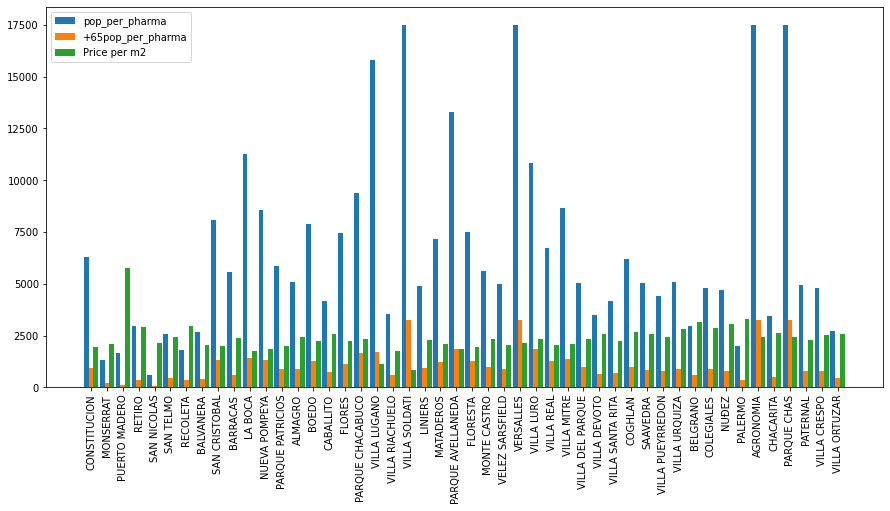

In [48]:
# Let´s make a bar chart with main features to get the firsts insights.

import matplotlib
import matplotlib.pyplot as plt

x = np.arange(len(df_merged2))  # the label locations
plt.figure(figsize=(15,7))
plt.bar(x - 0.3, df_merged2['pop_per_pharma'], 0.3, label = 'pop_per_pharma')
plt.bar(x, df_merged2['+65pop_per_pharma'], 0.3, label = '+65pop_per_pharma')
plt.bar(x + 0.3, df_merged2['USD/m2'], 0.3, label = 'Price per m2')

plt.xticks(x, df_merged2['Neighborhood'])

plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.show()

In [49]:
#Prepare data for k-means
k_means_data_A=df_merged2.drop(['Neighborhood', 'Total_pop', 'Total_pop_+65', 'Pharmacies','+65pop_per_pharma'], axis=1)
k_means_data_B=df_merged2.drop(['Neighborhood', 'Total_pop', 'Total_pop_+65', 'Pharmacies','pop_per_pharma'], axis=1)

In [51]:
#check data
print (k_means_data_A.head())
print (k_means_data_B.head())

   USD/m2  pop_per_pharma
0    1960     6301.000000
1    2083     1330.466667
2    5786     1681.500000
3    2926     2973.318182
4    2163      609.854167
   USD/m2  +65pop_per_pharma
0    1960         930.714286
1    2083         195.600000
2    5786         122.500000
3    2926         378.909091
4    2163          90.104167


In [52]:
#scale data
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
k_means_data_A_scaled = pd.DataFrame(ss.fit_transform(k_means_data_A),columns = k_means_data_A.columns)
k_means_data_B_scaled = pd.DataFrame(ss.fit_transform(k_means_data_B),columns = k_means_data_B.columns)

In [53]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans_A = KMeans(n_clusters=kclusters, random_state=0).fit(k_means_data_A_scaled)
kmeans_B = KMeans(n_clusters=kclusters, random_state=0).fit(k_means_data_B_scaled)


# check cluster labels generated for each row in the dataframe
kmeans_A.labels_[0:10]
kmeans_B.labels_[0:10]

array([3, 3, 2, 0, 3, 3, 0, 3, 1, 3])

In [54]:
# Assign labels an take look of data
df_merged2['cluster_A']=kmeans_A.labels_
df_merged2['cluster_B']=kmeans_B.labels_
df_merged2.head()

,Neighborhood,Total_pop,Total_pop_+65,Pharmacies,USD/m2,pop_per_pharma,+65pop_per_pharma,cluster_A,cluster_B
0,CONSTITUCION,44107.0,6515.0,7.0,1960,6301.000000,930.714286,0,3
1,MONSERRAT,39914.0,5868.0,30.0,2083,1330.466667,195.600000,2,3
2,PUERTO MADERO,6726.0,490.0,4.0,5786,1681.500000,122.500000,3,2
3,RETIRO,65413.0,8336.0,22.0,2926,2973.318182,378.909091,1,0
4,SAN NICOLAS,29273.0,4325.0,48.0,2163,609.854167,90.104167,2,3


In [55]:
#build pivot tables to analyse results of dataframe A
def my25(g):
    return np.nanpercentile(g, 25)

def my75(g):
    return np.nanpercentile(g, 75)

table_A_a = pd.pivot_table(df_merged2, values=['pop_per_pharma'], index=['cluster_A'],
                    aggfunc=[my25, np.median, my75, np.mean,np.std])
table_A_a=table_A_a.swaplevel(i=0, j=1, axis=1)

table_A_b = pd.pivot_table(df_merged2, values=['USD/m2'], index=['cluster_A'],
                    aggfunc=[my25, np.median, my75, np.mean,np.std])
table_A_b=table_A_b.swaplevel(i=0, j=1, axis=1)

table_cluster_A=pd.merge(table_A_a, table_A_b, left_index=True, right_index=True, how='outer')
table_cluster_A

pop_per_pharma                                            \
                    my25        median          my75          mean   
cluster_A                                                            
0            7391.366162   7993.083333   8853.729167   8320.793771   
1            2949.558140   3501.105263   4777.363636   3802.563851   
2            3308.663462   4862.336601   5034.950175   4129.154186   
3            1681.500000   1681.500000   1681.500000   1681.500000   
4           16219.812500  17489.000000  17489.000000  16510.000000   

                         USD/m2                                            
                   std     my25  median     my75         mean         std  
cluster_A                                                                  
0          1537.371980  1952.25  2075.0  2229.75  2079.583333  178.458275  
1          1318.784161  2591.00  2801.0  2973.00  2829.615385  243.788343  
2          1564.791434  2074.75  2282.0  2376.50  2235.375000  202.111809  
3                  NaN  5786.00  5786.0  5786.00  5786.000000         NaN  
4          1708.806433  1304.25  2000.5  2354.75  1802.166667  677.952629

In [56]:
#build pivot tables to analyse results of dataframe B
table_B_a = pd.pivot_table(df_merged2, values=['+65pop_per_pharma'], index=['cluster_B'],
                    aggfunc=[my25, np.median, my75, np.mean,np.std])
table_B_a=table_B_a.swaplevel(i=0, j=1, axis=1)

table_B_b = pd.pivot_table(df_merged2, values=['USD/m2'], index=['cluster_B'],
                    aggfunc=[my25, np.median, my75, np.mean,np.std])
table_B_b=table_B_b.swaplevel(i=0, j=1, axis=1)

table_cluster_B=pd.merge(table_B_a, table_B_b, left_index=True, right_index=True, how='outer')
table_cluster_B

+65pop_per_pharma                                         \
                       my25       median         my75         mean   
cluster_B                                                            
0                454.281250   713.090226   836.709091   661.099453   
1               1267.333333  1339.325000  1663.000000  1455.698611   
2                122.500000   122.500000   122.500000   122.500000   
3                582.500000   799.000000   916.000000   718.061710   
4               3277.000000  3277.000000  3277.000000  3277.000000   

                        USD/m2                                            
                  std     my25  median     my75         mean         std  
cluster_B                                                                 
0          222.061422  2588.75  2745.5  2961.25  2808.000000  247.794580  
1          233.443425  1864.50  2040.5  2146.50  1977.500000  324.094964  
2                 NaN  5786.00  5786.0  5786.00  5786.000000         NaN  
3          288.909237  2050.00  2261.0  2357.00  2201.823529  191.114898  
4            0.000000  1828.25  2289.5  2422.75  1961.500000  760.791036

## Results

In [57]:
#Print results
for j in range(0, kclusters):
    print("Cluster_A_"+str(j)+" neighborhoods:\n", df_merged2.loc[(df_merged2['cluster_A'] ==j)]['Neighborhood'].to_list(),"\n")

for j in range(0, kclusters):
    print("Cluster_B_"+str(j)+" neighborhoods:\n", df_merged2.loc[(df_merged2['cluster_B'] ==j)]['Neighborhood'].to_list(),"\n")

Cluster_A_0 neighborhoods:
 ['CONSTITUCION', 'SAN CRISTOBAL', 'LA BOCA', 'NUEVA POMPEYA', 'BOEDO', 'FLORES', 'PARQUE CHACABUCO', 'MATADEROS', 'FLORESTA', 'VILLA LURO', 'VILLA REAL', 'VILLA MITRE'] 

Cluster_A_1 neighborhoods:
 ['RETIRO', 'RECOLETA', 'CABALLITO', 'VILLA DEVOTO', 'COGHLAN', 'SAAVEDRA', 'VILLA URQUIZA', 'BELGRANO', 'COLEGIALES', 'NUÐEZ', 'PALERMO', 'CHACARITA', 'VILLA ORTUZAR'] 

Cluster_A_2 neighborhoods:
 ['MONSERRAT', 'SAN NICOLAS', 'SAN TELMO', 'BALVANERA', 'BARRACAS', 'PARQUE PATRICIOS', 'ALMAGRO', 'VILLA RIACHUELO', 'LINIERS', 'MONTE CASTRO', 'VELEZ SARSFIELD', 'VILLA DEL PARQUE', 'VILLA SANTA RITA', 'VILLA PUEYRREDON', 'PATERNAL', 'VILLA CRESPO'] 

Cluster_A_3 neighborhoods:
 ['PUERTO MADERO'] 

Cluster_A_4 neighborhoods:
 ['VILLA LUGANO', 'VILLA SOLDATI', 'PARQUE AVELLANEDA', 'VERSALLES', 'AGRONOMIA', 'PARQUE CHAS'] 

Cluster_B_0 neighborhoods:
 ['RETIRO', 'RECOLETA', 'CABALLITO', 'VILLA DEVOTO', 'COGHLAN', 'SAAVEDRA', 'VILLA URQUIZA', 'BELGRANO', 'COLEGIALES', 'N

In [58]:
# lets merge cluster_A=4 and cluster_B=4, which represents neighborhoods with the highest value of popoluation per pharmacies. 
# Regarding Income, although they both have the lowest values within each cluster, they are not strongly lower than the other
# clusters

df_merged2.loc[(df_merged2['cluster_A'] ==4) & (df_merged2['cluster_B'] == 4)]

,Neighborhood,Total_pop,Total_pop_+65,Pharmacies,USD/m2,pop_per_pharma,+65pop_per_pharma,cluster_A,cluster_B
20,VILLA SOLDATI,46779.0,3603.0,0.0,836,17489.0,3277.0,4,4
27,VERSALLES,13822.0,2503.0,0.0,2159,17489.0,3277.0,4,4
42,AGRONOMIA,13912.0,2489.0,0.0,2420,17489.0,3277.0,4,4
44,PARQUE CHAS,17489.0,3277.0,1.0,2431,17489.0,3277.0,4,4


In [59]:
# plot recommended neighborhoods

gp_neighborhoods=geopandas.read_file('C:/coursera_final_capstone/barrios.geojson')
map_caba_neigh = folium.Map(location=[latitude, longitude], zoom_start=11)
cluster_A_4=df_merged2.loc[(df_merged2['cluster_A'] ==4)]['Neighborhood'].to_list()
style = {'fillColor': 'green'}

for neighborhood in cluster_A_4:
    folium.GeoJson(gp_neighborhoods.loc[gp_neighborhoods['barrio']==neighborhood],style_function = lambda x: style).add_to(map_caba_neigh)
   #folium.GeoJson(gp_neighborhoods.loc[gp_neighborhoods['barrio']==neighborhood]).add_to(map_caba_neigh)

map_caba_neigh